# Modelo Completo

Como anexo a la práctica, voy a intentar construir el modelo completo de red neuronal. Usando variables sintéticas

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as randint
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.optimizers import Nadam
from keras.layers import Dropout
#from imblearn.under_sampling import NearMiss

import tensorflow as tf

tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=4))



Cargamos los datos:

In [2]:

%matplotlib inline

datos_path = "./"
clientes_file = "Clientes_train.csv"
zonas_file = "Zonas.csv"

clientes = pd.read_csv(os.path.join(datos_path, clientes_file), sep='\t')
zonas = pd.read_csv(os.path.join(datos_path, zonas_file), sep='\t')

datos = pd.merge(clientes, zonas, on="ID_Zona", how="inner")



clientes_file_2 = "Clientes_test.csv"


clientes2 = pd.read_csv(os.path.join(datos_path, clientes_file_2), sep='\t')
zonas = pd.read_csv(os.path.join(datos_path, zonas_file), sep='\t')

datos2 = pd.merge(clientes2, zonas, on="ID_Zona", how="inner")

#targets2 = datos2["Seguro_Vivienda"]
#variables2 = datos2.drop(["Seguro_Vivienda"], axis=1, inplace=False)



X_test_2 = datos2._get_numeric_data()

In [3]:
datos.head()

,ID_Cliente,Fecha_Nacimiento,Fecha_Alta,Sexo,ID_Zona,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,...,Poblacion_Funcionario,Poblacion_Trabajador_Cualificado,Poblacion_Trabajador_No_Cualificado,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000
0,C3088,29/03/1968,27/03/1989,Mujer,Z1143,0,1,0,0.0,617.55,...,28.17,21.01,27.13,71.34,28.66,32.77,67.23,2.23,1.47,96.3
1,C3441,01/05/1962,26/12/1984,Hombre,Z1143,0,0,0,0.0,0.00,...,28.17,21.01,27.13,71.34,28.66,32.77,67.23,2.23,1.47,96.3
2,C0412,19/01/1967,29/04/1987,Hombre,Z1143,0,0,1,0.0,0.00,...,28.17,21.01,27.13,71.34,28.66,32.77,67.23,2.23,1.47,96.3
3,C3565,20/04/1948,06/09/1969,Hombre,Z1143,0,1,0,0.0,3315.54,...,28.17,21.01,27.13,71.34,28.66,32.77,67.23,2.23,1.47,96.3
4,C0315,28/07/1979,18/06/2001,Mujer,Z1143,0,1,2,0.0,2561.45,...,28.17,21.01,27.13,71.34,28.66,32.77,67.23,2.23,1.47,96.3


In [4]:
datos2.head()

,ID_Cliente,Fecha_Nacimiento,Fecha_Alta,Sexo,ID_Zona,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,...,Poblacion_Funcionario,Poblacion_Trabajador_Cualificado,Poblacion_Trabajador_No_Cualificado,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000
0,C2172,05/10/1981,04/02/2005,Hombre,Z0403,1,2,2,735.14,2535.49,...,41.42,0.00,0.00,33.04,66.96,78.78,21.22,0.0,0.0,100.00
1,C3005,05/04/1974,26/11/1995,Hombre,Z0403,0,0,1,0.00,0.00,...,41.42,0.00,0.00,33.04,66.96,78.78,21.22,0.0,0.0,100.00
2,C1627,21/09/1983,27/12/2004,Mujer,Z0700,0,1,1,0.00,3195.94,...,46.35,16.59,1.30,0.00,100.00,31.24,68.76,0.0,0.0,100.00
3,C3120,16/02/1986,24/09/2007,Mujer,Z0700,0,3,0,0.00,4610.12,...,46.35,16.59,1.30,0.00,100.00,31.24,68.76,0.0,0.0,100.00
4,C0649,24/01/1945,02/12/1967,Hombre,Z1023,0,0,0,0.00,0.00,...,21.16,19.46,41.63,17.29,82.71,17.86,82.14,0.0,8.9,91.11



Creamos variables sintéticas para ámbas tablas: Edad (años) y Antiguedad (meses):

In [5]:

datos['Edad'] = ((pd.to_datetime("06/10/2018", format='%d/%m/%Y') - pd.to_datetime(datos.Fecha_Nacimiento, format='%d/%m/%Y')) 
          /np.timedelta64(1, 'Y')).astype(int)

datos['Antiguedad'] = ((pd.to_datetime("06/10/2018", format='%d/%m/%Y') - pd.to_datetime(datos.Fecha_Alta, format='%d/%m/%Y')) 
          /np.timedelta64(1, 'M')).astype(int)

datos['Sexo_2'] = 0
datos['Sexo_2'][datos.Sexo=='Hombre'] =1


datos2['Edad'] = ((pd.to_datetime("06/10/2018", format='%d/%m/%Y') - pd.to_datetime(datos.Fecha_Nacimiento, format='%d/%m/%Y')) 
          /np.timedelta64(1, 'Y')).astype(int)

datos2['Antiguedad'] = ((pd.to_datetime("06/10/2018", format='%d/%m/%Y') - pd.to_datetime(datos.Fecha_Alta, format='%d/%m/%Y')) 
          /np.timedelta64(1, 'M')).astype(int)

datos2['Sexo_2'] = 0
datos2['Sexo_2'][datos2.Sexo=='Hombre'] =1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:

datos.head()

,ID_Cliente,Fecha_Nacimiento,Fecha_Alta,Sexo,ID_Zona,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,...,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000,Edad,Antiguedad,Sexo_2
0,C3088,29/03/1968,27/03/1989,Mujer,Z1143,0,1,0,0.0,617.55,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,50,354,0
1,C3441,01/05/1962,26/12/1984,Hombre,Z1143,0,0,0,0.0,0.00,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,56,405,1
2,C0412,19/01/1967,29/04/1987,Hombre,Z1143,0,0,1,0.0,0.00,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,51,377,1
3,C3565,20/04/1948,06/09/1969,Hombre,Z1143,0,1,0,0.0,3315.54,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,70,588,1
4,C0315,28/07/1979,18/06/2001,Mujer,Z1143,0,1,2,0.0,2561.45,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,39,207,0


In [7]:
datos2.head()

,ID_Cliente,Fecha_Nacimiento,Fecha_Alta,Sexo,ID_Zona,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,...,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000,Edad,Antiguedad,Sexo_2
0,C2172,05/10/1981,04/02/2005,Hombre,Z0403,1,2,2,735.14,2535.49,...,33.04,66.96,78.78,21.22,0.0,0.0,100.00,50,354,1
1,C3005,05/04/1974,26/11/1995,Hombre,Z0403,0,0,1,0.00,0.00,...,33.04,66.96,78.78,21.22,0.0,0.0,100.00,56,405,1
2,C1627,21/09/1983,27/12/2004,Mujer,Z0700,0,1,1,0.00,3195.94,...,0.00,100.00,31.24,68.76,0.0,0.0,100.00,51,377,0
3,C3120,16/02/1986,24/09/2007,Mujer,Z0700,0,3,0,0.00,4610.12,...,0.00,100.00,31.24,68.76,0.0,0.0,100.00,70,588,0
4,C0649,24/01/1945,02/12/1967,Hombre,Z1023,0,0,0,0.00,0.00,...,17.29,82.71,17.86,82.14,0.0,8.9,91.11,39,207,1


Preparamos la tabla para entrenar

### Remuestreo

In [8]:
datos_ext = datos

for i in range(0,3):
    datos_ext = datos_ext.append(datos_ext[datos_ext.Seguro_Vivienda==1])

datos_ext[datos_ext.Seguro_Vivienda==1]
#datos_ext

,ID_Cliente,Fecha_Nacimiento,Fecha_Alta,Sexo,ID_Zona,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,...,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000,Edad,Antiguedad,Sexo_2
11,C1947,10/09/1948,08/09/1973,Hombre,Z1201,1,0,2,492.21,3890.19,...,92.04,7.96,43.84,56.16,0.00,3.38,96.62,70,540,1
34,C2877,05/11/1966,19/11/1988,Hombre,Z0789,0,1,3,0.00,6712.59,...,100.00,0.00,20.08,79.92,0.00,0.00,100.00,51,358,1
41,C1031,04/02/1980,20/01/2001,Mujer,Z0789,0,1,2,0.00,6824.90,...,100.00,0.00,20.08,79.92,0.00,0.00,100.00,38,212,0
60,C1093,29/10/1948,18/03/1970,Hombre,Z0664,0,1,2,0.00,5915.24,...,16.11,83.89,1.91,98.09,0.00,0.00,100.01,69,582,1
69,C3214,03/03/1948,02/09/1970,Hombre,Z1707,0,1,2,0.00,6262.06,...,100.00,0.00,70.70,29.30,16.02,12.17,71.81,70,577,1
84,C2780,27/07/1952,13/10/1972,Hombre,Z0738,0,1,2,0.00,6246.52,...,79.05,20.95,0.00,100.00,0.00,0.00,100.00,66,551,1
109,C0013,29/11/1973,08/08/2000,Hombre,Z0314,0,1,1,0.00,7616.57,...,5.65,94.35,0.00,100.00,0.00,6.53,93.47,44,217,1
138,C2650,17/04/1986,01/12/2006,Mujer,Z1112,0,1,0,0.00,3529.81,...,0.00,100.00,8.78,91.22,0.00,9.59,90.41,32,142,0
153,C1412,06/04/1971,05/06/1991,Hombre,Z0522,0,3,2,0.00,8725.95,...,100.00,0.00,77.26,22.74,0.00,21.57,78.43,47,328,1
157,C0799,16/12/1989,15/08/2009,Mujer,Z0522,0,1,1,0.00,5042.51,...,100.00,0.00,77.26,22.74,0.00,21.57,78.43,28,109,0


In [9]:
targets = datos["Seguro_Vivienda"]
variables = datos.drop(["Seguro_Vivienda", "ID_Cliente", "Fecha_Nacimiento", "Fecha_Alta", "Sexo", "ID_Zona"], axis=1, inplace=False)

In [10]:
targets.head()

0    False
1    False
2    False
3    False
4    False
Name: Seguro_Vivienda, dtype: bool

In [11]:
variables.head()

,Productos_Vida,Productos_Vehiculos,Productos_Otros,Gasto_Vida,Gasto_Vehiculos,Gasto_Otros,Tipo_Familia,Tipo_Pareja,Tipo_Soltero,Educacion_Superior,...,Vivienda_Propiedad,Vivienda_Alquiler,Medico_Seguro_Privado,Medico_Seguridad_Social,Ingresos_Mas_De_40000,Ingresos_De_20000_Hasta_40000,Ingresos_Hasta_20000,Edad,Antiguedad,Sexo_2
0,0,1,0,0.0,617.55,0.00,75.1,18.27,6.63,2.75,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,50,354,0
1,0,0,0,0.0,0.00,0.00,75.1,18.27,6.63,2.75,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,56,405,1
2,0,0,1,0.0,0.00,197.14,75.1,18.27,6.63,2.75,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,51,377,1
3,0,1,0,0.0,3315.54,0.00,75.1,18.27,6.63,2.75,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,70,588,1
4,0,1,2,0.0,2561.45,176.94,75.1,18.27,6.63,2.75,...,71.34,28.66,32.77,67.23,2.23,1.47,96.3,39,207,0


In [12]:

X_train, X_test, y_train, y_test = train_test_split(
    variables, targets, test_size=0.2, random_state=42)

y_train = y_train*1
y_test = y_test*1

#### Escalado

In [13]:

scale = StandardScaler()

X_scale_train = scale.fit_transform(X_train)
X_scale_test = scale.transform(X_test)

#X_scale_train = X_scale_train.reshape((len(X_scale_train), np.prod(X_scale_train.shape[1:])))
#X_scale_test = X_scale_test.reshape((len(X_scale_test), np.prod(X_scale_test.shape[1:])))

#y_cat_train = y_train*1
#y_cat_test = y_test*1

#Necesitamos este paso para poder probar con dos neuronas en la última capa
y_cat_train = to_categorical(y_train.astype(int))
y_cat_test = to_categorical(y_test.astype(int))

#y_cat_train[1:50]
#y_train[1:50]

## Red Neuronal

In [14]:
# por lo que veo en las últimas versiones han quitado alguna métrica de Keras, pero en esta ruta están implementadas muchas:
# https://github.com/GeekLiB/keras/blob/master/keras/metrics.py
# tengo dudas si el recall es correcto, pero luego saldremos de dudas cuando veamos las curvas ROC en el siguiente notebook

from keras import backend as K

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score



In [63]:
l=0.01
rate = 0.1
x = Input(shape=(26,))
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(x)
layer = Dropout(rate)(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = Dropout(rate)(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = Dropout(rate)(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = Dropout(rate)(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = Dropout(rate)(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = Dropout(rate)(layer)
layer = BatchNormalization()(layer)
layer = Dense(100, activation='softsign', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
layer = Dropout(rate)(layer)
layer = BatchNormalization()(layer)
y = Dense(1, activation='sigmoid',kernel_initializer='he_uniform')(layer)
mlp = Model(x, y)

In [64]:
nadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

#callback = [EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)]
mlp.compile(optimizer='nadam',
            loss='binary_crossentropy',
            metrics=['accuracy', recall, fbeta_score])

In [65]:
mlp.fit(X_scale_train, y_train,
                epochs=1000,
                batch_size=10,
                shuffle=True,
#                callbacks = callback,
                 validation_split=0.1)

Train on 2106 samples, validate on 235 samples
Epoch 1/1000
2106/2106 [==============================] - 6s 3ms/step - loss: 37.3646 - acc: 0.8476 - recall: 0.0867 - fbeta_score: 0.0553 - val_loss: 8.7820 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 2/1000
2106/2106 [==============================] - 1s 551us/step - loss: 4.4858 - acc: 0.9112 - recall: 0.0166 - fbeta_score: 0.0182 - val_loss: 1.7479 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 3/1000
2106/2106 [==============================] - 1s 563us/step - loss: 2.2673 - acc: 0.9311 - recall: 0.0195 - fbeta_score: 0.0147 - val_loss: 4.6572 - val_acc: 0.6255 - val_recall: 0.4681 - val_fbeta_score: 0.1942
Epoch 4/1000
2106/2106 [==============================] - 1s 561us/step - loss: 2.0246 - acc: 0.9283 - recall: 0.0182 - fbeta_score: 0.0214 - val_loss: 1.5094 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 5/1000
2106/2106 [==========

Epoch 36/1000
2106/2106 [==============================] - 1s 547us/step - loss: 1.0527 - acc: 0.9411 - recall: 0.0071 - fbeta_score: 0.0079 - val_loss: 0.8126 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 37/1000
2106/2106 [==============================] - 1s 545us/step - loss: 1.0737 - acc: 0.9416 - recall: 0.0071 - fbeta_score: 0.0079 - val_loss: 0.9343 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 38/1000
2106/2106 [==============================] - 1s 614us/step - loss: 0.9122 - acc: 0.9383 - recall: 0.0040 - fbeta_score: 0.0055 - val_loss: 0.8153 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 39/1000
2106/2106 [==============================] - 1s 627us/step - loss: 0.8641 - acc: 0.9402 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.7836 - val_acc: 0.9447 - val_recall: 0.0213 - val_fbeta_score: 0.0284
Epoch 40/1000
2106/2106 [==============================] - 2s 813us/step - l

2106/2106 [==============================] - 1s 665us/step - loss: 0.7056 - acc: 0.9421 - recall: 0.0380 - fbeta_score: 0.0396 - val_loss: 0.5716 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 72/1000
2106/2106 [==============================] - 1s 676us/step - loss: 0.6542 - acc: 0.9425 - recall: 0.0285 - fbeta_score: 0.0285 - val_loss: 0.5669 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 73/1000
2106/2106 [==============================] - 1s 545us/step - loss: 0.6368 - acc: 0.9406 - recall: 0.0142 - fbeta_score: 0.0142 - val_loss: 0.5919 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 74/1000
2106/2106 [==============================] - 1s 533us/step - loss: 0.6500 - acc: 0.9402 - recall: 0.0000e+00 - fbeta_score: 0.0000e+00 - val_loss: 0.4913 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 75/1000
2106/2106 [==============================] - 1s 494us/step -

2106/2106 [==============================] - 1s 492us/step - loss: 0.4706 - acc: 0.9406 - recall: 0.0301 - fbeta_score: 0.0309 - val_loss: 0.5440 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 107/1000
2106/2106 [==============================] - 1s 485us/step - loss: 0.5305 - acc: 0.9411 - recall: 0.0142 - fbeta_score: 0.0142 - val_loss: 0.6345 - val_acc: 0.8681 - val_recall: 0.4468 - val_fbeta_score: 0.3504
Epoch 108/1000
2106/2106 [==============================] - 1s 588us/step - loss: 0.5072 - acc: 0.9373 - recall: 0.0047 - fbeta_score: 0.0047 - val_loss: 0.4068 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 109/1000
2106/2106 [==============================] - 1s 508us/step - loss: 0.4850 - acc: 0.9406 - recall: 0.0166 - fbeta_score: 0.0174 - val_loss: 0.6706 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 110/1000
2106/2106 [==============================] - 1s 567us/step - loss: 0.523

2106/2106 [==============================] - 2s 774us/step - loss: 0.4965 - acc: 0.9364 - recall: 0.0166 - fbeta_score: 0.0174 - val_loss: 0.4629 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 142/1000
2106/2106 [==============================] - 1s 691us/step - loss: 0.4720 - acc: 0.9387 - recall: 0.0332 - fbeta_score: 0.0348 - val_loss: 0.4383 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 143/1000
2106/2106 [==============================] - 1s 658us/step - loss: 0.4261 - acc: 0.9430 - recall: 0.0237 - fbeta_score: 0.0253 - val_loss: 0.4218 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 144/1000
2106/2106 [==============================] - 2s 750us/step - loss: 0.4495 - acc: 0.9397 - recall: 0.0142 - fbeta_score: 0.0142 - val_loss: 0.3928 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 145/1000
2106/2106 [==============================] - 1s 709us/step - los

2106/2106 [==============================] - 1s 499us/step - loss: 0.3979 - acc: 0.9387 - recall: 0.0000e+00 - fbeta_score: 0.0000e+00 - val_loss: 0.3547 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 177/1000
2106/2106 [==============================] - 1s 503us/step - loss: 0.4038 - acc: 0.9411 - recall: 0.0071 - fbeta_score: 0.0079 - val_loss: 0.3901 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 178/1000
2106/2106 [==============================] - 1s 504us/step - loss: 0.4104 - acc: 0.9397 - recall: 0.0047 - fbeta_score: 0.0047 - val_loss: 0.3707 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 179/1000
2106/2106 [==============================] - 1s 511us/step - loss: 0.4148 - acc: 0.9406 - recall: 0.0071 - fbeta_score: 0.0079 - val_loss: 0.4553 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 180/1000
2106/2106 [==============================] - 1s 515us/st

2106/2106 [==============================] - 1s 505us/step - loss: 0.4078 - acc: 0.9411 - recall: 0.0071 - fbeta_score: 0.0079 - val_loss: 0.3970 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 212/1000
2106/2106 [==============================] - 1s 502us/step - loss: 0.3819 - acc: 0.9406 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3801 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 213/1000
2106/2106 [==============================] - 1s 515us/step - loss: 0.3714 - acc: 0.9392 - recall: 0.0000e+00 - fbeta_score: 0.0000e+00 - val_loss: 0.3864 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 214/1000
2106/2106 [==============================] - 1s 511us/step - loss: 0.3747 - acc: 0.9411 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3612 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 215/1000
2106/2106 [==============================] - 1s 506us/st

Epoch 246/1000
2106/2106 [==============================] - 1s 543us/step - loss: 0.3573 - acc: 0.9387 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3398 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 247/1000
2106/2106 [==============================] - 1s 541us/step - loss: 0.3631 - acc: 0.9406 - recall: 0.0047 - fbeta_score: 0.0047 - val_loss: 0.3504 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 248/1000
2106/2106 [==============================] - 1s 537us/step - loss: 0.3716 - acc: 0.9416 - recall: 0.0142 - fbeta_score: 0.0142 - val_loss: 0.3578 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 249/1000
2106/2106 [==============================] - 1s 549us/step - loss: 0.3532 - acc: 0.9402 - recall: 0.0047 - fbeta_score: 0.0047 - val_loss: 0.4059 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 250/1000
2106/2106 [==============================] - 1s 5

Epoch 281/1000
2106/2106 [==============================] - 1s 558us/step - loss: 0.3515 - acc: 0.9406 - recall: 0.0190 - fbeta_score: 0.0190 - val_loss: 0.3652 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 282/1000
2106/2106 [==============================] - 1s 632us/step - loss: 0.3780 - acc: 0.9421 - recall: 0.0285 - fbeta_score: 0.0285 - val_loss: 0.4034 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 283/1000
2106/2106 [==============================] - 1s 594us/step - loss: 0.3701 - acc: 0.9383 - recall: 0.0190 - fbeta_score: 0.0190 - val_loss: 0.3711 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 284/1000
2106/2106 [==============================] - 1s 570us/step - loss: 0.3704 - acc: 0.9387 - recall: 0.0190 - fbeta_score: 0.0190 - val_loss: 0.3353 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 285/1000
2106/2106 [==============================] - 1s 5

2106/2106 [==============================] - 1s 624us/step - loss: 0.3543 - acc: 0.9402 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3616 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 317/1000
2106/2106 [==============================] - 1s 630us/step - loss: 0.3713 - acc: 0.9392 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3306 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 318/1000
2106/2106 [==============================] - 2s 826us/step - loss: 0.3630 - acc: 0.9402 - recall: 0.0000e+00 - fbeta_score: 0.0000e+00 - val_loss: 0.3321 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 319/1000
2106/2106 [==============================] - 2s 763us/step - loss: 0.3613 - acc: 0.9416 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3484 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 320/1000
2106/2106 [==============================] - 2s 803us/st

Epoch 351/1000
2106/2106 [==============================] - 1s 597us/step - loss: 0.3758 - acc: 0.9411 - recall: 0.0071 - fbeta_score: 0.0079 - val_loss: 0.4111 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 352/1000
2106/2106 [==============================] - 1s 623us/step - loss: 0.3721 - acc: 0.9406 - recall: 0.0047 - fbeta_score: 0.0047 - val_loss: 0.3570 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 353/1000
2106/2106 [==============================] - 1s 651us/step - loss: 0.3498 - acc: 0.9406 - recall: 0.0000e+00 - fbeta_score: 0.0000e+00 - val_loss: 0.3733 - val_acc: 0.9489 - val_recall: 0.0638 - val_fbeta_score: 0.0709
Epoch 354/1000
2106/2106 [==============================] - 1s 578us/step - loss: 0.3555 - acc: 0.9411 - recall: 0.0047 - fbeta_score: 0.0047 - val_loss: 0.3208 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 355/1000
2106/2106 [==============================] - 1s 6

Epoch 386/1000
2106/2106 [==============================] - 1s 476us/step - loss: 0.3445 - acc: 0.9402 - recall: 0.0142 - fbeta_score: 0.0158 - val_loss: 0.3228 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 387/1000
2106/2106 [==============================] - 1s 493us/step - loss: 0.3448 - acc: 0.9421 - recall: 0.0119 - fbeta_score: 0.0127 - val_loss: 0.3206 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 388/1000
2106/2106 [==============================] - 1s 486us/step - loss: 0.3370 - acc: 0.9421 - recall: 0.0285 - fbeta_score: 0.0301 - val_loss: 0.3344 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 389/1000
2106/2106 [==============================] - 1s 488us/step - loss: 0.3687 - acc: 0.9397 - recall: 0.0071 - fbeta_score: 0.0079 - val_loss: 0.3654 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 390/1000
2106/2106 [==============================] - 1s 5

2106/2106 [==============================] - 1s 518us/step - loss: 0.3394 - acc: 0.9402 - recall: 0.0087 - fbeta_score: 0.0103 - val_loss: 0.3472 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 422/1000
2106/2106 [==============================] - 1s 484us/step - loss: 0.3443 - acc: 0.9383 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3705 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 423/1000
2106/2106 [==============================] - 1s 487us/step - loss: 0.3540 - acc: 0.9402 - recall: 0.0000e+00 - fbeta_score: 0.0000e+00 - val_loss: 0.3506 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 424/1000
2106/2106 [==============================] - 1s 491us/step - loss: 0.3574 - acc: 0.9411 - recall: 0.0237 - fbeta_score: 0.0237 - val_loss: 0.3516 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 425/1000
2106/2106 [==============================] - 1s 478us/st

Epoch 456/1000
2106/2106 [==============================] - 1s 478us/step - loss: 0.3530 - acc: 0.9397 - recall: 0.0190 - fbeta_score: 0.0190 - val_loss: 0.3247 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 457/1000
2106/2106 [==============================] - 1s 487us/step - loss: 0.3379 - acc: 0.9406 - recall: 0.0166 - fbeta_score: 0.0174 - val_loss: 0.3441 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 458/1000
2106/2106 [==============================] - 1s 476us/step - loss: 0.3395 - acc: 0.9402 - recall: 0.0000e+00 - fbeta_score: 0.0000e+00 - val_loss: 0.3645 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 459/1000
2106/2106 [==============================] - 1s 481us/step - loss: 0.3513 - acc: 0.9402 - recall: 0.0190 - fbeta_score: 0.0190 - val_loss: 0.3434 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 460/1000
2106/2106 [==============================

Epoch 491/1000
2106/2106 [==============================] - 1s 594us/step - loss: 0.3576 - acc: 0.9406 - recall: 0.0158 - fbeta_score: 0.0166 - val_loss: 0.3156 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 492/1000
2106/2106 [==============================] - 1s 651us/step - loss: 0.3446 - acc: 0.9411 - recall: 0.0166 - fbeta_score: 0.0174 - val_loss: 0.3450 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 493/1000
2106/2106 [==============================] - 1s 647us/step - loss: 0.3305 - acc: 0.9373 - recall: 0.0119 - fbeta_score: 0.0127 - val_loss: 0.3304 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 494/1000
2106/2106 [==============================] - 1s 617us/step - loss: 0.3773 - acc: 0.9416 - recall: 0.0071 - fbeta_score: 0.0079 - val_loss: 0.4135 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 495/1000
2106/2106 [==============================] - 1s 6

2106/2106 [==============================] - 1s 524us/step - loss: 0.3520 - acc: 0.9435 - recall: 0.0332 - fbeta_score: 0.0348 - val_loss: 0.3498 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 527/1000
2106/2106 [==============================] - 1s 541us/step - loss: 0.3446 - acc: 0.9416 - recall: 0.0190 - fbeta_score: 0.0190 - val_loss: 0.3218 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 528/1000
2106/2106 [==============================] - 1s 529us/step - loss: 0.3650 - acc: 0.9411 - recall: 0.0166 - fbeta_score: 0.0174 - val_loss: 0.4196 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 529/1000
2106/2106 [==============================] - 1s 525us/step - loss: 0.3609 - acc: 0.9416 - recall: 0.0047 - fbeta_score: 0.0063 - val_loss: 0.3598 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 530/1000
2106/2106 [==============================] - 1s 518us/step - los

2106/2106 [==============================] - 1s 630us/step - loss: 0.3257 - acc: 0.9430 - recall: 0.0285 - fbeta_score: 0.0301 - val_loss: 0.3427 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 562/1000
2106/2106 [==============================] - 1s 630us/step - loss: 0.3494 - acc: 0.9397 - recall: 0.0142 - fbeta_score: 0.0142 - val_loss: 0.3594 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 563/1000
2106/2106 [==============================] - 1s 623us/step - loss: 0.3612 - acc: 0.9406 - recall: 0.0166 - fbeta_score: 0.0174 - val_loss: 0.3756 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 564/1000
2106/2106 [==============================] - 1s 621us/step - loss: 0.3518 - acc: 0.9392 - recall: 0.0142 - fbeta_score: 0.0142 - val_loss: 0.3371 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 565/1000
2106/2106 [==============================] - 1s 607us/step - los

2106/2106 [==============================] - 1s 503us/step - loss: 0.3557 - acc: 0.9416 - recall: 0.0119 - fbeta_score: 0.0127 - val_loss: 0.3646 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 596/1000
2106/2106 [==============================] - 1s 503us/step - loss: 0.3778 - acc: 0.9397 - recall: 0.0285 - fbeta_score: 0.0301 - val_loss: 0.3634 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 597/1000
2106/2106 [==============================] - 1s 503us/step - loss: 0.3546 - acc: 0.9435 - recall: 0.0427 - fbeta_score: 0.0427 - val_loss: 0.3635 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 598/1000
2106/2106 [==============================] - 1s 507us/step - loss: 0.3478 - acc: 0.9416 - recall: 0.0142 - fbeta_score: 0.0142 - val_loss: 0.3157 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 599/1000
2106/2106 [==============================] - 1s 528us/step - los

2106/2106 [==============================] - 1s 545us/step - loss: 0.3581 - acc: 0.9406 - recall: 0.0142 - fbeta_score: 0.0142 - val_loss: 0.3518 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 631/1000
2106/2106 [==============================] - 1s 547us/step - loss: 0.3408 - acc: 0.9402 - recall: 0.0047 - fbeta_score: 0.0047 - val_loss: 0.3269 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 632/1000
2106/2106 [==============================] - 1s 548us/step - loss: 0.3394 - acc: 0.9397 - recall: 0.0119 - fbeta_score: 0.0127 - val_loss: 0.3526 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 633/1000
2106/2106 [==============================] - 1s 541us/step - loss: 0.3605 - acc: 0.9397 - recall: 0.0111 - fbeta_score: 0.0119 - val_loss: 0.3659 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 634/1000
2106/2106 [==============================] - 1s 548us/step - los

2106/2106 [==============================] - 1s 579us/step - loss: 0.3488 - acc: 0.9416 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3289 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 666/1000
2106/2106 [==============================] - 1s 579us/step - loss: 0.3434 - acc: 0.9402 - recall: 0.0095 - fbeta_score: 0.0111 - val_loss: 0.3477 - val_acc: 0.9532 - val_recall: 0.1915 - val_fbeta_score: 0.1844
Epoch 667/1000
2106/2106 [==============================] - 1s 581us/step - loss: 0.3499 - acc: 0.9430 - recall: 0.0309 - fbeta_score: 0.0317 - val_loss: 0.3150 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 668/1000
2106/2106 [==============================] - 1s 574us/step - loss: 0.3327 - acc: 0.9411 - recall: 0.0285 - fbeta_score: 0.0285 - val_loss: 0.3763 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 669/1000
2106/2106 [==============================] - 1s 630us/step - loss: 0.353

2106/2106 [==============================] - 1s 505us/step - loss: 0.3460 - acc: 0.9397 - recall: 0.0119 - fbeta_score: 0.0127 - val_loss: 0.3379 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 701/1000
2106/2106 [==============================] - 1s 514us/step - loss: 0.3439 - acc: 0.9406 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3350 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 702/1000
2106/2106 [==============================] - 1s 509us/step - loss: 0.3398 - acc: 0.9416 - recall: 0.0237 - fbeta_score: 0.0237 - val_loss: 0.3443 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 703/1000
2106/2106 [==============================] - 1s 506us/step - loss: 0.3373 - acc: 0.9406 - recall: 0.0214 - fbeta_score: 0.0222 - val_loss: 0.3167 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 704/1000
2106/2106 [==============================] - 1s 508us/step - los

Epoch 735/1000
2106/2106 [==============================] - 1s 500us/step - loss: 0.3545 - acc: 0.9406 - recall: 0.0237 - fbeta_score: 0.0237 - val_loss: 0.3434 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 736/1000
2106/2106 [==============================] - 1s 506us/step - loss: 0.3504 - acc: 0.9368 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3416 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 737/1000
2106/2106 [==============================] - 1s 500us/step - loss: 0.3409 - acc: 0.9425 - recall: 0.0356 - fbeta_score: 0.0364 - val_loss: 0.3353 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 738/1000
2106/2106 [==============================] - 1s 539us/step - loss: 0.3441 - acc: 0.9416 - recall: 0.0261 - fbeta_score: 0.0269 - val_loss: 0.3291 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 739/1000
2106/2106 [==============================] - 1s 5

Epoch 770/1000
2106/2106 [==============================] - 1s 504us/step - loss: 0.3713 - acc: 0.9397 - recall: 0.0166 - fbeta_score: 0.0174 - val_loss: 0.3800 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 771/1000
2106/2106 [==============================] - 1s 518us/step - loss: 0.3650 - acc: 0.9411 - recall: 0.0142 - fbeta_score: 0.0142 - val_loss: 0.3569 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 772/1000
2106/2106 [==============================] - 1s 564us/step - loss: 0.3696 - acc: 0.9411 - recall: 0.0451 - fbeta_score: 0.0459 - val_loss: 0.3778 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 773/1000
2106/2106 [==============================] - 1s 601us/step - loss: 0.3592 - acc: 0.9383 - recall: 0.0182 - fbeta_score: 0.0214 - val_loss: 0.3651 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 774/1000
2106/2106 [==============================] - 1s 6

2106/2106 [==============================] - 1s 484us/step - loss: 0.3524 - acc: 0.9402 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3276 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 806/1000
2106/2106 [==============================] - 1s 479us/step - loss: 0.3967 - acc: 0.9397 - recall: 0.0071 - fbeta_score: 0.0079 - val_loss: 0.3188 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 807/1000
2106/2106 [==============================] - 1s 494us/step - loss: 0.3389 - acc: 0.9430 - recall: 0.0190 - fbeta_score: 0.0190 - val_loss: 0.3624 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 808/1000
2106/2106 [==============================] - 1s 488us/step - loss: 0.3618 - acc: 0.9425 - recall: 0.0261 - fbeta_score: 0.0269 - val_loss: 0.2961 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 809/1000
2106/2106 [==============================] - 1s 485us/step - los

2106/2106 [==============================] - 1s 490us/step - loss: 0.3591 - acc: 0.9383 - recall: 0.0024 - fbeta_score: 0.0032 - val_loss: 0.3597 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 841/1000
2106/2106 [==============================] - 1s 486us/step - loss: 0.3434 - acc: 0.9421 - recall: 0.0380 - fbeta_score: 0.0380 - val_loss: 0.3169 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 842/1000
2106/2106 [==============================] - 1s 484us/step - loss: 0.3615 - acc: 0.9416 - recall: 0.0190 - fbeta_score: 0.0190 - val_loss: 0.4255 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 843/1000
2106/2106 [==============================] - 1s 483us/step - loss: 0.3640 - acc: 0.9411 - recall: 0.0142 - fbeta_score: 0.0142 - val_loss: 0.4324 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 844/1000
2106/2106 [==============================] - 1s 481us/step - los

Epoch 875/1000
2106/2106 [==============================] - 1s 486us/step - loss: 0.3420 - acc: 0.9406 - recall: 0.0142 - fbeta_score: 0.0142 - val_loss: 0.3473 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 876/1000
2106/2106 [==============================] - 1s 488us/step - loss: 0.3322 - acc: 0.9378 - recall: 0.0190 - fbeta_score: 0.0190 - val_loss: 0.3182 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 877/1000
2106/2106 [==============================] - 1s 479us/step - loss: 0.3493 - acc: 0.9383 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3127 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 878/1000
2106/2106 [==============================] - 1s 493us/step - loss: 0.3586 - acc: 0.9402 - recall: 0.0047 - fbeta_score: 0.0063 - val_loss: 0.3349 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 879/1000
2106/2106 [==============================] - 1s 4

2106/2106 [==============================] - 1s 550us/step - loss: 0.3487 - acc: 0.9402 - recall: 0.0142 - fbeta_score: 0.0142 - val_loss: 0.3084 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 911/1000
2106/2106 [==============================] - 1s 553us/step - loss: 0.3519 - acc: 0.9411 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3336 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 912/1000
2106/2106 [==============================] - 1s 538us/step - loss: 0.3607 - acc: 0.9406 - recall: 0.0166 - fbeta_score: 0.0174 - val_loss: 0.3518 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 913/1000
2106/2106 [==============================] - 1s 546us/step - loss: 0.3459 - acc: 0.9373 - recall: 0.0237 - fbeta_score: 0.0237 - val_loss: 0.3293 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 914/1000
2106/2106 [==============================] - 1s 548us/step - los

2106/2106 [==============================] - 1s 639us/step - loss: 0.3478 - acc: 0.9411 - recall: 0.0166 - fbeta_score: 0.0174 - val_loss: 0.3590 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 946/1000
2106/2106 [==============================] - 1s 563us/step - loss: 0.3562 - acc: 0.9397 - recall: 0.0000e+00 - fbeta_score: 0.0000e+00 - val_loss: 0.3396 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 947/1000
2106/2106 [==============================] - 1s 670us/step - loss: 0.3496 - acc: 0.9416 - recall: 0.0285 - fbeta_score: 0.0285 - val_loss: 0.3471 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 948/1000
2106/2106 [==============================] - 1s 531us/step - loss: 0.3464 - acc: 0.9392 - recall: 0.0095 - fbeta_score: 0.0095 - val_loss: 0.3209 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 949/1000
2106/2106 [==============================] - 1s 517us/st

2106/2106 [==============================] - 1s 585us/step - loss: 0.3219 - acc: 0.9402 - recall: 0.0182 - fbeta_score: 0.0198 - val_loss: 0.2945 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 981/1000
2106/2106 [==============================] - 1s 597us/step - loss: 0.3427 - acc: 0.9406 - recall: 0.0071 - fbeta_score: 0.0079 - val_loss: 0.3034 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 982/1000
2106/2106 [==============================] - 1s 607us/step - loss: 0.3482 - acc: 0.9387 - recall: 0.0000e+00 - fbeta_score: 0.0000e+00 - val_loss: 0.3218 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 983/1000
2106/2106 [==============================] - 1s 610us/step - loss: 0.3720 - acc: 0.9383 - recall: 0.0071 - fbeta_score: 0.0079 - val_loss: 0.3239 - val_acc: 0.9404 - val_recall: 0.0000e+00 - val_fbeta_score: 0.0000e+00
Epoch 984/1000
2106/2106 [==============================] - 1s 535us/st

In [66]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 26)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 100)               2700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 100)               400       
_________________________________________________________________
dense_59 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 100)               400       
__________

In [67]:
mlp.evaluate(X_scale_test, y_test)

586/586 [==============================] - 0s 84us/step


[0.3067373134475519, 0.9539249146757679, 0.0, 0.0]

### ROC

In [68]:
y_score = mlp.predict(X_scale_test)
#y_score =y_score[:,1]>y_score[:,0]
y_score[0:100]
#y_test[0:100]

roc_auc_score(y_test, y_score)

0.9338103756708407

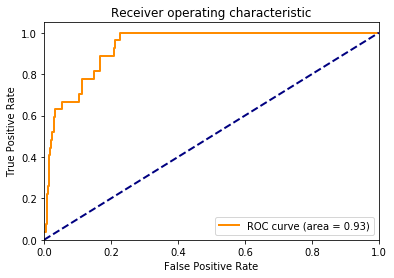

In [69]:
# Compute ROC curve and ROC area for each class



# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Bastante similar al modelo de una capa, esto me hace pensar que la opción "class_weight='balanced'" funciona bastante bien.